#Predictive Analytics with Time Series Forecasting
###Problem Statement:
Create a time series forecasting model for predicting future values based on historical
data. Use a dataset such as the Daily Climate Time Series Data.


1. **Objective:**
   - The primary goal is to develop a time series forecasting model that can predict future values based on patterns and trends observed in historical data. This is particularly useful for predicting how a certain variable (e.g., temperature) will change over time.

2. **Time Series Forecasting:**
   - Time series forecasting involves using historical data to make predictions about future values of a time-dependent variable. This type of analysis is common in various fields, including finance, weather forecasting, and resource planning.

3. **Dataset:**
   - The dataset mentioned for training is the Daily Climate Time Series Data. This dataset likely contains historical records of climate-related variables collected at regular intervals (daily, in this case).

4. **Time Series Data:**
   - Time series data is a sequence of observations recorded over time. Each data point is associated with a specific time, and the goal is often to predict future values based on the historical pattern of the data.

5. **Input Data:**
   - The input data for this problem consists of historical records of climate-related variables, such as temperature, collected on a daily basis. Each data point includes a timestamp and the observed value of the variable.

6. **Time Series Forecasting Model:**
   - The model for time series forecasting can vary, but common approaches include autoregressive integrated moving average (ARIMA) models, seasonal decomposition of time series (STL), and more advanced methods like recurrent neural networks (RNNs) or long short-term memory networks (LSTMs).

7. **Training:**
   - The model is trained on the Daily Climate Time Series Data. During training, the model learns to capture the patterns and trends in the historical data, enabling it to make accurate predictions about future values.

8. **Evaluation:**
   - The performance of the time series forecasting model is evaluated on a separate dataset, typically a test set from the Daily Climate Time Series Data. Common evaluation metrics include mean absolute error (MAE), mean squared error (MSE), or root mean squared error (RMSE).

9. **Application:**
   - Once the model is trained and validated, it can be used to predict future values of the climate-related variable. This has practical applications in weather forecasting, resource management, and other domains where understanding and predicting trends over time are crucial.

In [1]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Conv1D, Lambda
from tensorflow.keras.optimizers import SGD

In [2]:
def plot_accuracy(history):
    mae = history.history['mae']
    loss = history.history['loss']

    epochs = range(len(mae))

    # -----------------------------------------------------------
    # Retrieve a list of list results on training and test data
    # sets for each training epoch
    # -----------------------------------------------------------

    plt.plot(epochs, mae, 'b', label='Training mae')
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy Vs Testing Accuracy')
    plt.legend()
    plt.figure()

    # # ------------------------------------------------
    # # Plot mae and loss per epoch skipping the first 50
    # # ------------------------------------------------
    epochs = range(len(mae) - 50)
    plt.plot(epochs, mae[50:], 'b', label='Training Loss')
    plt.plot(epochs, loss[50:], 'r', label='Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Vs Testing Losss')
    plt.legend()

In [3]:
def plot_series(time, series, label=None, start=0, stop=None):
    plt.plot(time[start:stop], series[start:stop], label=label)
    plt.xlabel('Time')
    plt.ylabel('temp')

file_path = r'/content/drive/MyDrive/dataset/rainfall.csv'

In [4]:
def get_data(data_path):
    time = 0
    series = []
    with open(data_path, 'r') as delhi_temp:
        reader = csv.reader(delhi_temp)
        next(reader)
        for row in reader:
            series.append(float(row[1]))
            time += 1

    series = np.array(series)
    time = np.array(range(time))
    return time, series

<Figure size 640x480 with 0 Axes>

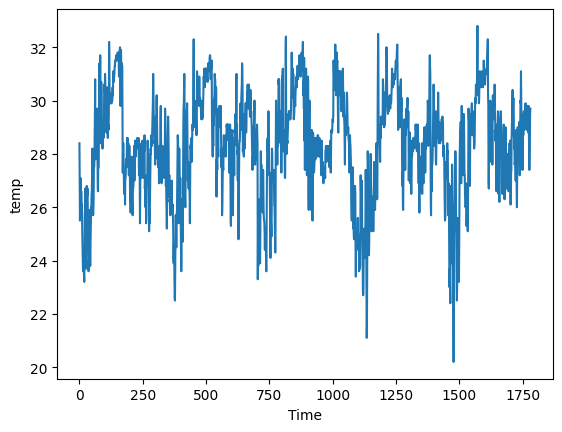

<Figure size 640x480 with 0 Axes>

In [5]:
time, series = get_data(file_path)
plot_series(time, series, label='Entire Dataset')
plt.figure()

In [6]:
split = 1000  # Choose an appropriate split point
train_time = time[:split]
test_time = time[split:]
train_series = series[:split]
test_series = series[split:]

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size)
    dataset = dataset.shuffle(shuffle_buffer).prefetch(1)

    return dataset

In [8]:
def prediction_data(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)

    forecast = model.predict(dataset)
    return forecast

In [9]:
window_size = 32
batch_size = 1024
shuffle_buffer = 10000

train_dataset = windowed_dataset(train_series, window_size, batch_size, shuffle_buffer)

model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv1D(64, 5, padding='causal', activation='relu', input_shape=[None,1]), #64
        tf.keras.layers.Bidirectional(LSTM(120, return_sequences=True)), #64
        tf.keras.layers.Bidirectional(LSTM(64)), #32
        tf.keras.layers.Dense(64, activation='relu'), #32
        tf.keras.layers.Dense(32, activation='relu'), #12
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda( lambda x : x * 40.0)
    ]
)

In [12]:
model.compile(optimizer=SGD(learning_rate=4.7e-5), loss=tf.keras.losses.Huber(), metrics=['mae'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 64)          384       
                                                                 
 bidirectional (Bidirection  (None, None, 240)         177600    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               156160    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 3

In [17]:
history = model.fit(train_dataset, epochs=500, verbose=2) #, callbacks=[lr_scheduler])

Epoch 1/500
1/1 - 2s - loss: 0.6895 - mae: 1.0875 - 2s/epoch - 2s/step
Epoch 2/500
1/1 - 3s - loss: 0.6830 - mae: 1.0946 - 3s/epoch - 3s/step
Epoch 3/500
1/1 - 3s - loss: 0.6833 - mae: 1.0801 - 3s/epoch - 3s/step
Epoch 4/500
1/1 - 5s - loss: 0.6819 - mae: 1.0940 - 5s/epoch - 5s/step
Epoch 5/500
1/1 - 4s - loss: 0.6898 - mae: 1.0879 - 4s/epoch - 4s/step
Epoch 6/500
1/1 - 2s - loss: 0.6831 - mae: 1.0949 - 2s/epoch - 2s/step
Epoch 7/500
1/1 - 2s - loss: 0.6833 - mae: 1.0801 - 2s/epoch - 2s/step
Epoch 8/500
1/1 - 2s - loss: 0.6813 - mae: 1.0933 - 2s/epoch - 2s/step
Epoch 9/500
1/1 - 2s - loss: 0.6886 - mae: 1.0865 - 2s/epoch - 2s/step
Epoch 10/500
1/1 - 3s - loss: 0.6821 - mae: 1.0938 - 3s/epoch - 3s/step
Epoch 11/500
1/1 - 2s - loss: 0.6823 - mae: 1.0789 - 2s/epoch - 2s/step
Epoch 12/500
1/1 - 2s - loss: 0.6803 - mae: 1.0923 - 2s/epoch - 2s/step
Epoch 13/500
1/1 - 2s - loss: 0.6877 - mae: 1.0854 - 2s/epoch - 2s/step
Epoch 14/500
1/1 - 2s - loss: 0.6811 - mae: 1.0928 - 2s/epoch - 2s/step
E

<Figure size 640x480 with 0 Axes>

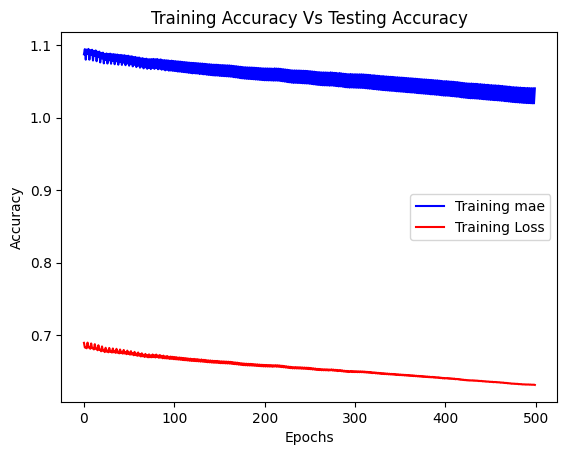

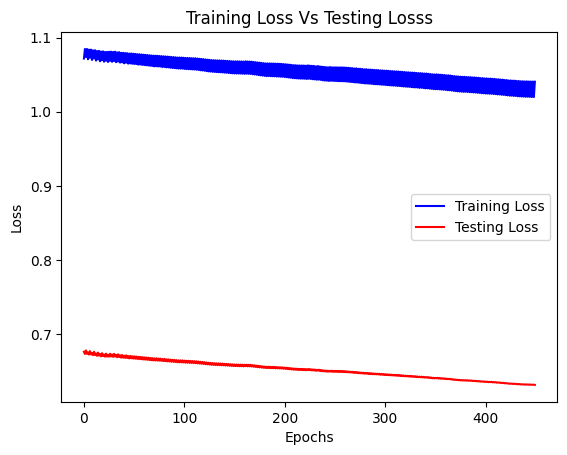

<Figure size 640x480 with 0 Axes>

In [18]:
plot_accuracy(history)
plt.figure()

In [19]:
forecast = prediction_data(model, series[..., np.newaxis], window_size, batch_size)
forecast = forecast[split - window_size:, -1]

2/2 [==============================] - 6s 802ms/step


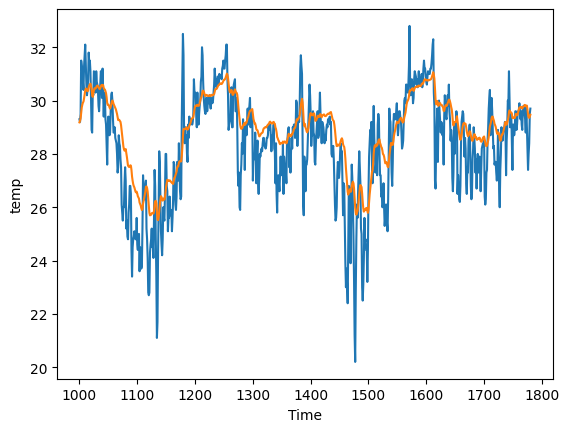

In [20]:
plot_series(test_time, test_series)
plot_series(test_time, forecast[1:])

In [21]:
mae = tf.keras.losses.mae(test_series, forecast[1:])
mse = tf.keras.losses.mse(test_series, forecast[1:])

In [22]:
print("MSE error: {}".format(mse))
print("MAE error: {}".format(mae))
plt.show()

MSE error: 1.6804622411727905
MAE error: 0.959365963935852
